# Calculating rise/set times with astropy

Coordinate system definitions:

| Parameter | Definition | 
|-----------|------------|
| $\alpha$  | Right ascension |
| $\delta$    | Declination |
| $\theta$ | Local sidereal time (LST) | 
| $\theta_0$ | LST in Greenwich | 
| $H$ | Local hour angle | 
| $\phi$ | Observer latitude | 
| $L$ | Observer longitude | 
| $h$ | Object altitude | 
| $A$ | Object azimuth | 

From Meeus' *Astronomical Algorithms* Equation 13.6, 

$$ \sin(h) = \sin(\phi) \sin(\delta) + \cos(\phi) \cos(\delta) \cos(H)$$

and since 

$$ H = \theta - \alpha = \theta_0 - L - \alpha,$$

$$ \sin(h) = \sin(\phi) \sin(\delta) + \cos(\phi) \cos(\delta) \cos(\theta_0 - L - \alpha)$$

65d18m22.8725s 21d29m52.6822s


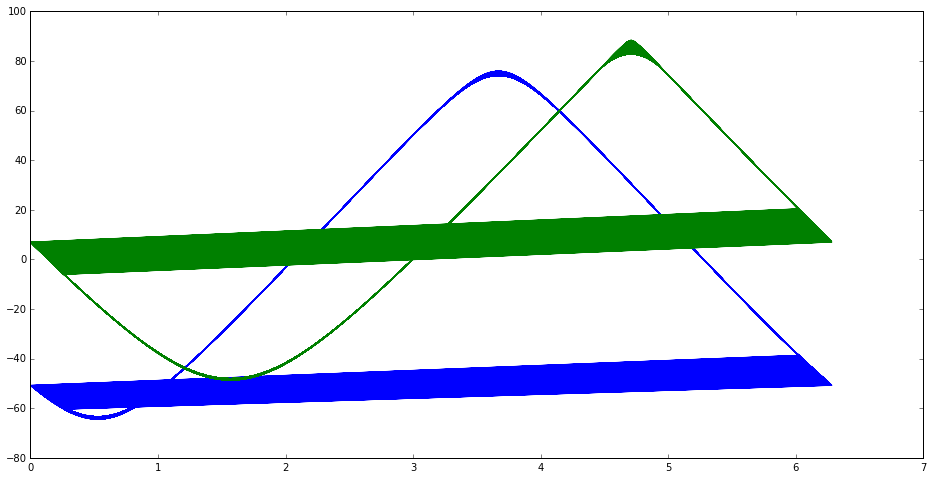

In [66]:
%matplotlib inline
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import numpy as np
import matplotlib.pyplot as plt
import datetime

# From astropy
import astropy.units as u
from astropy.coordinates import Angle, EarthLocation, Latitude, \
                                Longitude, get_sun
from astropy.time import Time

# IERS table patch from @eteq
from astropy.utils.data import download_file
from astropy.utils import iers
iers.IERS.iers_table = iers.IERS_A.open(download_file(iers.IERS_A_URL, cache=True))

# Some convenience functions
def get_altitude(location, RA, dec, LST_greenwich):
    alt = np.arcsin(np.sin(location.latitude.radian)*np.sin(dec) + 
                    np.cos(location.latitude.radian)*np.cos(dec) *
                    np.cos(LST_greenwich - 
                           location.longitude.radian - RA.radian))
    return alt

def daterange(t0, dt, N):
    '''
    t0 : datetime.datetime
        Initial time
    dt : float
        Number of hours between dates
    N : int
        Number of datetimes in range
    '''
    return [t0 + datetime.timedelta(hours=dt*i) for i in range(N)]

# Input observer location at Subaru
latitude = '+19:49:42.600'
longitude = '-155:28:48.900'
elevation = 0*u.m
location = EarthLocation(lat=latitude, lon=longitude,
                         height=elevation)

# Set up a range of dates, calculate LST
dates = daterange(datetime.datetime(2015,5,29), 1, 24*360)#30*6)
times = Time(dates, location=location)
LST_greenwich = times.sidereal_time('apparent', 'greenwich').radian

# Input fixed object coordinates
RA = Longitude(0.1*u.radian)
dec = Latitude(0.1*u.radian)

alt_star = get_altitude(location, RA, dec, LST_greenwich)

sun = get_sun(time)
alt_sun = get_altitude(location, sun.ra, sun.dec, LST_greenwich)
print(sun.ra, sun.dec)

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(LST_greenwich, alt_star.to('deg'))
ax.plot(LST_greenwich, alt_sun.to('deg'))
plt.show()

In [61]:
print(LST_greenwich.radian)

[ 4.29705484  4.55957099  4.82208715 ...,  5.57390474  5.83642089
  6.09893704]


In [14]:
print(location.latitude.radian)

0.346072610732


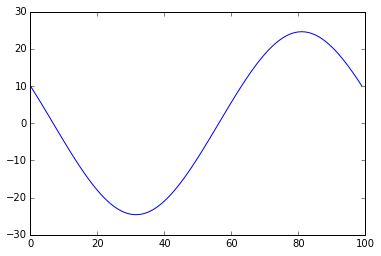

In [6]:
lat = 0
lon = 0
dec = 2
RA = 2
LST_greenwich = np.linspace(0, 2*np.pi, 100)



In [ ]:
lat = 0
lon = 0
dec = 2
RA = 2
LST_greenwich = np.linspace(0, 2*np.pi, 100)

alt = np.arcsin(np.sin(lat)*np.sin(dec) + np.cos(lat)*np.cos(dec)*
                np.cos(LST_greenwich - lon - RA))